## July 2024 CVE Data

In [1]:
%%capture
!mkdir -p jsondata
%cd jsondata
!rm *.json 
!rm *.zip 
!wget -q https://nvd.handsonhacking.org/nvd.jsonl

In [2]:

from IPython.core.magic import register_cell_magic
from IPython.display import Markdown
import calplot
import datetime
from datetime import date
import glob
import json
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

@register_cell_magic
def markdown(line, cell):
    return Markdown(cell.format(**globals()))


logging.getLogger('matplotlib.font_manager').disabled = True
warnings.filterwarnings("ignore")
pd.set_option('display.width', 500)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 10)

In [3]:
row_accumulator = []
for filename in glob.glob('nvd.jsonl'):
    with open(filename, 'r', encoding='utf-8') as f:
        nvd_data = json.load(f)
        for entry in nvd_data:
            cve = entry['cve']['id']
            try:
                assigner = entry['cve']['sourceIdentifier']
            except KeyError:
                assigner = 'Missing_Data'
            try:
                published_date = entry['cve']['published']
            except KeyError:
                published_date = 'Missing_Data'
            try:
                attack_vector = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['attackVector']
            except KeyError:
                attack_vector = 'Missing_Data'
            try:
                attack_complexity = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['attackComplexity']
            except KeyError:
                attack_complexity = 'Missing_Data'
            try:
                privileges_required = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['privilegesRequired']
            except KeyError:
                privileges_required = 'Missing_Data'
            try:
                user_interaction = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['userInteraction']
            except KeyError:
                user_interaction = 'Missing_Data'
            try:
                scope = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['scope']
            except KeyError:
                scope = 'Missing_Data'
            try:
                confidentiality_impact = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['confidentialityImpact']
            except KeyError:
                confidentiality_impact = 'Missing_Data'
            try:
                integrity_impact = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['integrityImpact']
            except KeyError:
                integrity_impact = 'Missing_Data'
            try:
                availability_impact = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['availabilityImpact']
            except KeyError:
                availability_impact = 'Missing_Data'
            try:
                base_score = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['baseScore']
            except KeyError:
                base_score = '0.0'
            try:
                base_severity = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['baseSeverity']
            except KeyError:
                base_severity = 'Missing_Data'
            try:
                exploitability_score = entry['cve']['metrics']['cvssMetricV31'][0]['exploitabilityScore']
            except KeyError:
                exploitability_score = 'Missing_Data'
            try:
                impact_score = entry['cve']['metrics']['cvssMetricV31'][0]['impactScore']
            except KeyError:
                impact_score = 'Missing_Data'
            try:
                cwe = entry['cve']['weaknesses'][0]['description'][0]['value']
            except KeyError:
                cwe = 'Missing_Data'
            try:
                description = entry['cve']['descriptions'][0]['value']
            except IndexError:
                description = ''
            new_row = {
                'CVE': cve,
                'Published': published_date,
                'AttackVector': attack_vector,
                'AttackComplexity': attack_complexity,
                'PrivilegesRequired': privileges_required,
                'UserInteraction': user_interaction,
                'Scope': scope,
                'ConfidentialityImpact': confidentiality_impact,
                'IntegrityImpact': integrity_impact,
                'AvailabilityImpact': availability_impact,
                'BaseScore': base_score,
                'BaseSeverity': base_severity,
                'ExploitabilityScore': exploitability_score,
                'ImpactScore': impact_score,
                'CWE': cwe,
                'Description': description,
                'Assigner' : assigner
            }
            if not description.startswith('rejected reason'): 
                row_accumulator.append(new_row)
        nvd = pd.DataFrame(row_accumulator)
        
    
nvd['Published'] = pd.to_datetime(nvd['Published'])
thisyear = ((nvd['Published'] > '2024-07-01') & (nvd['Published']  < '2024-08-01'))
nvd = nvd.loc[thisyear]
nvd = nvd.sort_values(by=['Published'])
nvd = nvd.reset_index(drop=True)
nvd['BaseScore'] = pd.to_numeric(nvd['BaseScore']);
nvd['BaseScore'] = pd.to_numeric(nvd['BaseScore']);
nvd['BaseScore'] = nvd['BaseScore'].replace(0, np.NaN);
nvdcount = nvd['Published'].count()
nvdunique = nvd['Published'].nunique()
startdate = date(2024, 7, 1)
enddate  = date(2024, 8, 1)
numberofdays = enddate - startdate 
per_day = nvdcount/numberofdays.days


In [4]:
Markdown(f"Total Number of CVEs: **{nvd['CVE'].count()}**<br />Average CVEs Per Day: **{per_day.round(2)}**<br />Average CVSS Score: **{nvd['BaseScore'].mean().round(2)}**")

Total Number of CVEs: **3174**<br />Average CVEs Per Day: **102.39**<br />Average CVSS Score: **6.73**

In [5]:
Markdown(f"## CVE Graphs")

## CVE Graphs

In [6]:
Month_Graph = nvd['Published'].groupby(nvd.Published.dt.to_period("M")).agg('count')
Year_Graph = nvd['Published'].groupby(nvd.Published.dt.to_period("Y")).agg('count')
Week_Graph = nvd['Published'].groupby(nvd.Published.dt.to_period("W")).agg('count')
Day_Graph = nvd['Published'].groupby(nvd.Published.dt.to_period("D")).agg('count')

In [7]:
Markdown(f"### CVE Calendar")

### CVE Calendar

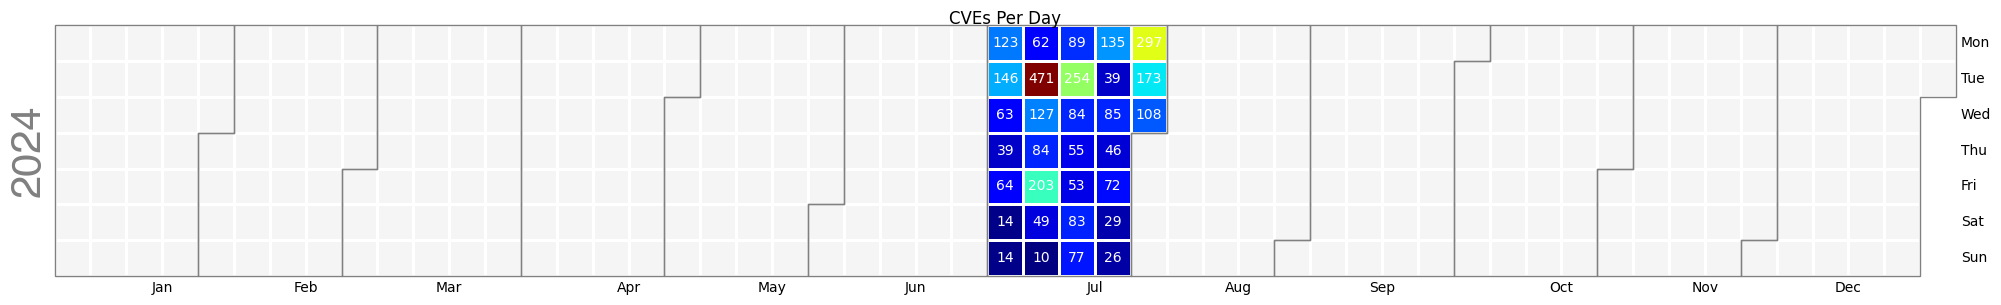

In [8]:
dfs = nvd['Published'].apply(lambda x: pd.to_datetime(x, errors='coerce', format='%Y/%m/%d'))
df = dfs.value_counts()
df = df.to_frame()
df.index = df.index.strftime('%m/%d/%Y')
df.index = pd.to_datetime(df.index, format='%m/%d/%Y')
calplot.calplot(df.T.squeeze(), cmap='jet', dropzero=True, edgecolor="Grey", textcolor="White", textformat='{:.0f}', textfiller='', suptitle='CVEs Per Day', figsize=(25,3));

In [9]:
Markdown(f"### CVE Per Week Graph")

### CVE Per Week Graph

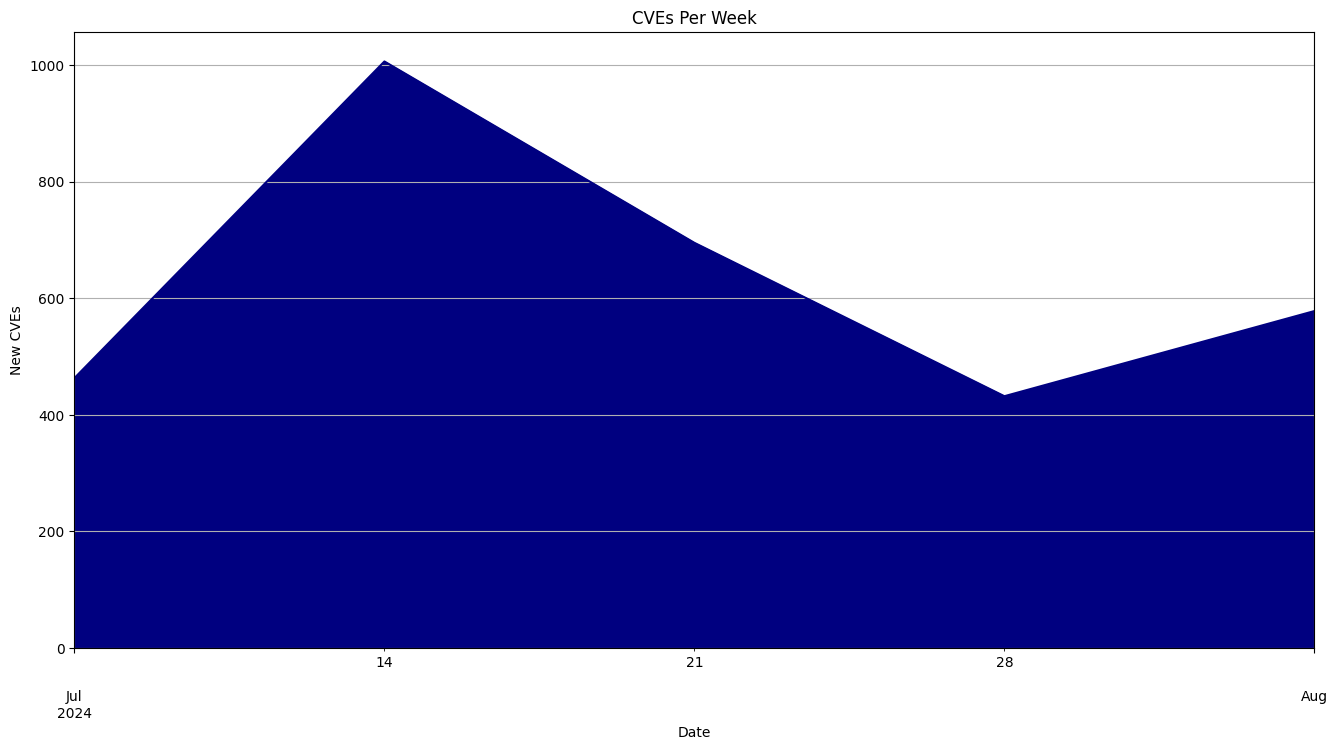

In [10]:

cg = Week_Graph.plot.area(colormap='jet', figsize=(16, 8), title='CVEs Per Week')
plt.grid()
cg.set_ylabel("New CVEs");
cg.set_xlabel("Date");

In [11]:
Markdown(f"### CVE Per Day Graph")

### CVE Per Day Graph

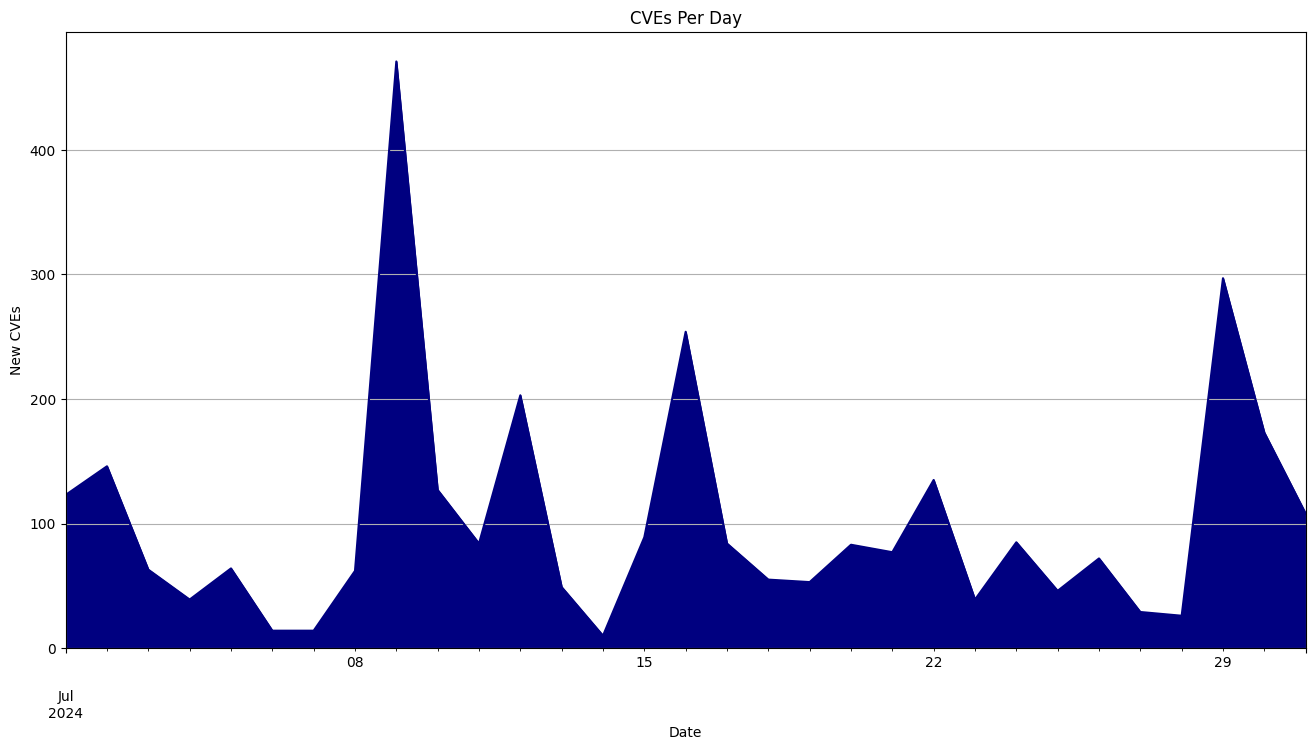

In [12]:

cg = Day_Graph.plot.area(colormap='jet', figsize=(16, 8), title='CVEs Per Day')
plt.grid()
cg.set_ylabel("New CVEs");
cg.set_xlabel("Date");

In [13]:
Markdown(f"## CVSS Data")

## CVSS Data

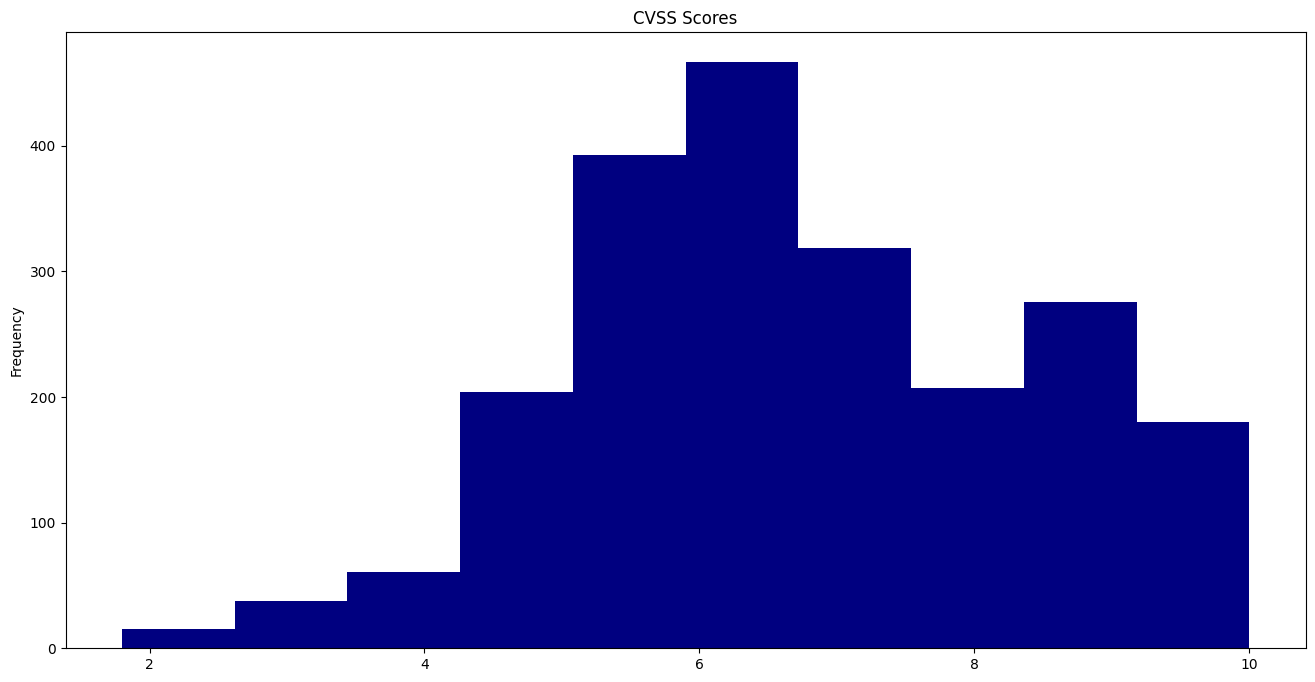

In [14]:
nvd['BaseScore'].plot(kind="hist", colormap='jet', figsize=(16, 8), title='CVSS Scores');

In [15]:
Markdown(f"## CNA Data")

## CNA Data

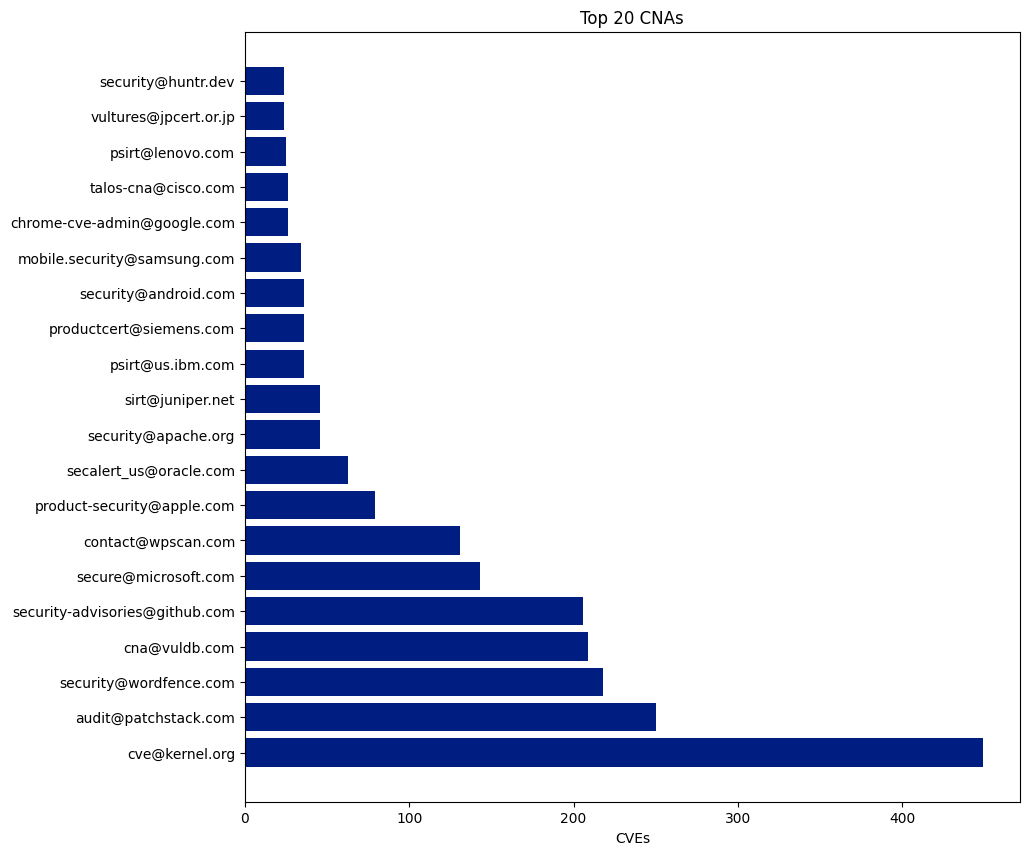

In [16]:
nvd['Assigner'].replace('416baaa9-dc9f-4396-8d5f-8c081fb06d67','cve@kernel.org',inplace=True)
nvd_frequency = nvd['Assigner'].value_counts()
nvd_frequency = nvd_frequency.reset_index()
nvd_frequency.columns = ['Assigner', 'counts']
nvd_frequency[nvd_frequency.counts > 100].head(50)
nvd_frequency_no_mitre = nvd_frequency[~nvd_frequency.Assigner.str.contains('cve@mitre.org')]
nvd_frequency_no_mitre = nvd_frequency_no_mitre.head(20)
plt.figure(figsize=(10,10))
plt.barh("Assigner", "counts", data = nvd_frequency_no_mitre, color="#001d82")
plt.xlabel("CVEs"); 
plt.ylabel("") ;
plt.title("Top 20 CNAs");


In [17]:
Markdown(f"## CWE Data")

## CWE Data

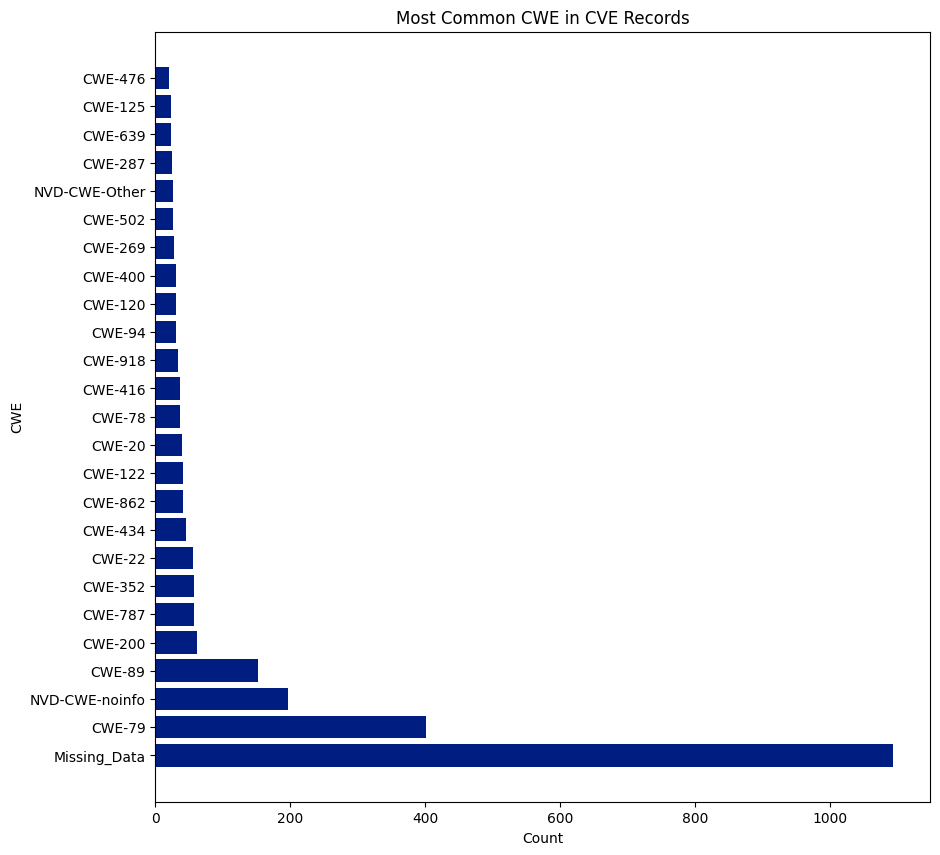

In [18]:
nvd_cwe = nvd['CWE'].value_counts()
nvd_cwe = nvd_cwe.reset_index()
nvd_cwe.columns = ['CWE', 'counts']
nvd_cwe = nvd_cwe.head(25)
plt.figure(figsize=(10,10));
plt.barh("CWE", "counts", data = nvd_cwe, color="#001d82");
plt.xlabel("Count"); 
plt.ylabel("CWE") ;
plt.title("Most Common CWE in CVE Records");


In [19]:
Markdown(f"## More CVE Data")

## More CVE Data

In [20]:
Markdown(f"### Top CNA Assigner")

### Top CNA Assigner

In [21]:
nvd_frequency_no_mitre.style.hide_index()

Assigner,counts
cve@kernel.org,449
audit@patchstack.com,250
security@wordfence.com,218
cna@vuldb.com,209
security-advisories@github.com,206
secure@microsoft.com,143
contact@wpscan.com,131
product-security@apple.com,79
secalert_us@oracle.com,63
security@apache.org,46


In [22]:
Markdown(f"### CVEs By Identifier")

### CVEs By Identifier

In [23]:

print("CVE-1999-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-1999-')]))
print("CVE-2000-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2000-')]))
print("CVE-2001-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2001-')]))
print("CVE-2002-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2002-')]))
print("CVE-2003-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2003-')]))
print("CVE-2004-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2004-')]))
print("CVE-2005-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2005-')]))
print("CVE-2006-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2006-')]))
print("CVE-2007-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2007-')]))
print("CVE-2008-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2008-')]))
print("CVE-2009-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2009-')]))
print("CVE-2010-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2010-')]))
print("CVE-2011-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2011-')]))
print("CVE-2012-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2012-')]))
print("CVE-2013-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2013-')]))
print("CVE-2014-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2014-')]))
print("CVE-2015-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2015-')]))
print("CVE-2016-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2016-')]))
print("CVE-2017-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2017-')]))
print("CVE-2018-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2018-')]))
print("CVE-2019-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2019-')]))
print("CVE-2020-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2020-')]))
print("CVE-2021-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2021-')]))
print("CVE-2022-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2022-')]))
print("CVE-2023-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2023-')]))
print("CVE-2024-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2024-')]))

CVE-1999-	0
CVE-2000-	0
CVE-2001-	0
CVE-2002-	0
CVE-2003-	0
CVE-2004-	0
CVE-2005-	0
CVE-2006-	0
CVE-2007-	0
CVE-2008-	0
CVE-2009-	0
CVE-2010-	0
CVE-2011-	0
CVE-2012-	0
CVE-2013-	0
CVE-2014-	0
CVE-2015-	0
CVE-2016-	1
CVE-2017-	4
CVE-2018-	0
CVE-2019-	14
CVE-2020-	5
CVE-2021-	3
CVE-2022-	118
CVE-2023-	135
CVE-2024-	2894


In [24]:
Markdown(f"### First 5 CVEs")

### First 5 CVEs

In [25]:
nvd[["CVE", "Description"]].head(5).style.hide_index()

CVE,Description
CVE-2024-6419,A vulnerability classified as critical was found in SourceCodester Medicine Tracker System 1.0. This vulnerability affects unknown code of the file /classes/Master.php?f=save_medicine. The manipulation of the argument id leads to sql injection. The attack can be initiated remotely. The exploit has been disclosed to the public and may be used. VDB-270010 is the identifier assigned to this vulnerability.
CVE-2024-20076,"In Modem, there is a possible system crash due to incorrect error handling. This could lead to remote denial of service with no additional execution privileges needed. User interaction is not needed for exploitation. Patch ID: MOLY01297806; Issue ID: MSV-1481."
CVE-2024-20077,"In Modem, there is a possible system crash due to incorrect error handling. This could lead to remote denial of service with no additional execution privileges needed. User interaction is not needed for exploitation. Patch ID: MOLY01297807; Issue ID: MSV-1482."
CVE-2024-20078,"In venc, there is a possible out of bounds write due to type confusion. This could lead to local escalation of privilege with System execution privileges needed. User interaction is not needed for exploitation. Patch ID: ALPS08737250; Issue ID: MSV-1452."
CVE-2024-20079,"In gnss service, there is a possible out of bounds write due to improper input validation. This could lead to local escalation of privilege with System execution privileges needed. User interaction is not needed for exploitation. Patch ID: ALPS08044040; Issue ID: MSV-1491."


In [26]:
Markdown(f"### Last 5 CVEs")

### Last 5 CVEs

In [27]:

nvd[["CVE", "Description"]].tail(5).style.hide_index()

CVE,Description
CVE-2024-41262,"mmudb v1.9.3 was discovered to use the HTTP protocol in the ShowMetricsRaw and ShowMetricsAsText functions, possibly allowing attackers to intercept communications via a man-in-the-middle attack."
CVE-2024-7327,A vulnerability classified as critical was found in Xinhu RockOA 2.6.2. This vulnerability affects the function dataAction of the file /webmain/task/openapi/openmodhetongAction.php. The manipulation of the argument nickName leads to sql injection. The attack can be initiated remotely. The exploit has been disclosed to the public and may be used. VDB-273250 is the identifier assigned to this vulnerability. NOTE: The vendor was contacted early about this disclosure but did not respond in any way.
CVE-2024-38182,Weak authentication in Microsoft Dynamics 365 allows an unauthenticated attacker to elevate privileges over a network.
CVE-2024-7328,"A vulnerability, which was classified as problematic, has been found in YouDianCMS 7. This issue affects some unknown processing of the file /t.php?action=phpinfo. The manipulation leads to information disclosure. The attack may be initiated remotely. The exploit has been disclosed to the public and may be used. The associated identifier of this vulnerability is VDB-273251. NOTE: The vendor was contacted early about this disclosure but did not respond in any way."
CVE-2024-7329,"A vulnerability, which was classified as critical, was found in YouDianCMS 7. Affected is an unknown function of the file /Public/ckeditor/plugins/multiimage/dialogs/image_upload.php. The manipulation of the argument files leads to unrestricted upload. It is possible to launch the attack remotely. The exploit has been disclosed to the public and may be used. The identifier of this vulnerability is VDB-273252. NOTE: The vendor was contacted early about this disclosure but did not respond in any way."
